# Parallel simulations

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/MultipleNetworks.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/MultipleNetworks.ipynb)

In [1]:
#!pip install ANNarchy

This example demonstrates the use of `parallel_run()` to simulate the same network multiple times in parallel. 

We start by creating the Izhikevich pulse-coupled network defined in [Izhikevich.ipynb](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/Izhikevich.ipynb).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ANNarchy as ann
ann.clear()

ANNarchy 4.8 (4.8.3) on darwin (posix).


## Using the magic network

In [3]:
# Create the whole population
P = ann.Population(geometry=1000, neuron=ann.Izhikevich)

# Create the excitatory population
Exc = P[:800]
re = np.random.random(800)
Exc.noise = 5.0
Exc.a = 0.02
Exc.b = 0.2
Exc.c = -65.0 + 15.0 * re**2
Exc.d = 8.0 - 6.0 * re**2
Exc.v = -65.0
Exc.u = Exc.v * Exc.b

# Create the Inh population
Inh = P[800:]
ri = np.random.random(200)
Inh.noise = 2.0
Inh.a = 0.02 + 0.08 * ri
Inh.b = 0.25 - 0.05 * ri
Inh.c = -65.0
Inh.d = 2.0
Inh.v = -65.0
Inh.u = Inh.v * Inh.b

# Create the projections
proj_exc = ann.Projection(Exc, P, 'exc')
proj_inh = ann.Projection(Inh, P, 'inh')

proj_exc.connect_all_to_all(weights=ann.Uniform(0.0, 0.5))
proj_inh.connect_all_to_all(weights=ann.Uniform(0.0, 1.0))

# Create a spike monitor
M = ann.Monitor(P, 'spike')

ann.compile()

Compiling ...  OK 


We define a simulation method that re-initializes the network, runs a simulation and returns a raster plot. 

The simulation method must take an index as first argument and a ``Network`` instance as second one.

In [4]:
def run_network(idx, net):
    
    # Retrieve subpopulations
    P_local = net.get(P)
    Exc = P_local[:800]
    Inh = P_local[800:]
    
    # Randomize initialization
    re = np.random.random(800)
    Exc.c = -65.0 + 15.0 * re**2
    Exc.d = 8.0 - 6.0 * re**2
    ri = np.random.random(200)
    Inh.noise = 2.0
    Inh.a = 0.02 + 0.08 * ri
    Inh.b = 0.25 - 0.05 * ri
    Inh.u = Inh.v * Inh.b
    
    # Simulate
    net.simulate(1000.)
    
    # Recordings
    t, n = net.get(M).raster_plot()
    
    return t, n


``parallel_run()`` uses the ``multiprocessing`` module to start parallel processes. On Linux, it should work directly, but there is an issue on OSX. Since Python 3.8, the 'spawn' method is the default way to start processes, but it does not work on MacOS. The following cell should fix the issue, but it should only be ran once.

In [5]:
import platform
if platform.system() == "Darwin":
    import multiprocessing as mp
    mp.set_start_method('fork')

We can now call ``parallel_run()`` to simulate 8 identical but differently initialized networks. The first call runs the simulations sequentially, while the second is in parallel.

We finally plot the raster plots of the two first simulations.

Running 8 networks sequentially took: 1.692439079284668 
Running 8 networks in parallel took: 0.44977307319641113 


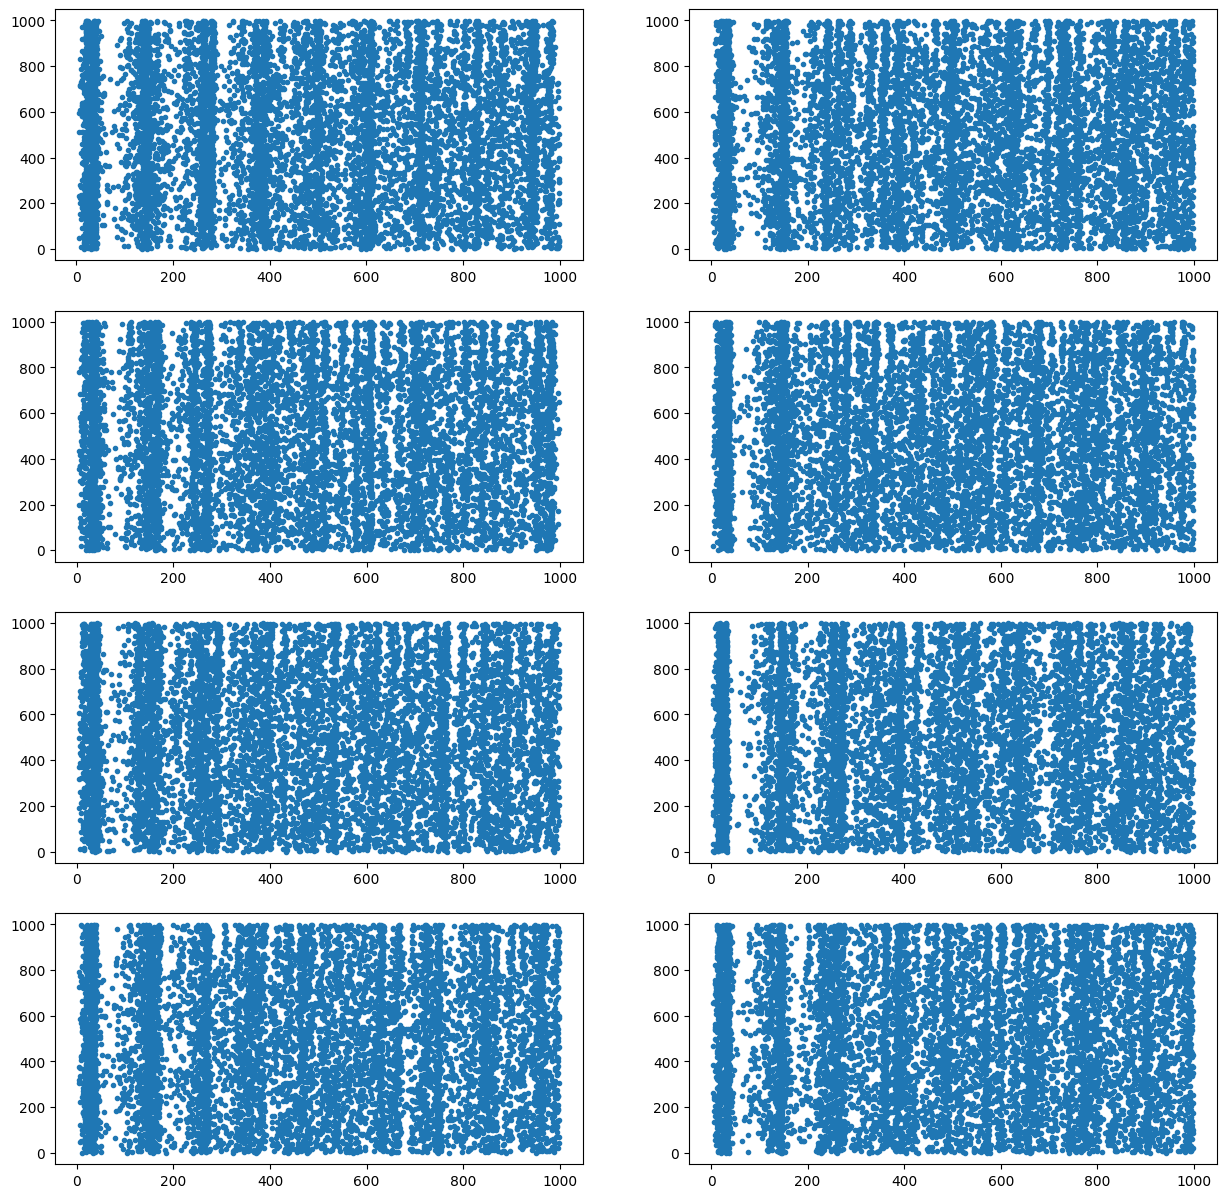

In [6]:
# Run four identical simulations sequentially
vals = ann.parallel_run(method=run_network, number=8, measure_time=True, sequential=True)

# Run four identical simulations in parallel
vals = ann.parallel_run(method=run_network, number=8, measure_time=True)

# Data analysis
plt.figure(figsize=(15, 15))
for i in range(8):
    t, n = vals[i]
    plt.subplot(4, 2, i+1)
    plt.plot(t, n, '.')
plt.show()

## Using the Network interface

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import ANNarchy as ann

class PulseNetwork(ann.Network):

    def __init__(self, seed=-1):

        if seed >=0 :
            self.set_seed(seed)

        # Create the population
        self.P = self.create(geometry=1000, neuron=ann.Izhikevich)

        # Create the excitatory population
        self.Exc = self.P[:800]
        re = np.random.random(800)
        self.Exc.noise = 5.0
        self.Exc.a = 0.02
        self.Exc.b = 0.2
        self.Exc.c = -65.0 + 15.0 * re**2
        self.Exc.d = 8.0 - 6.0 * re**2
        self.Exc.v = -65.0
        self.Exc.u = self.Exc.v * self.Exc.b

        # Create the Inh population
        self.Inh = self.P[800:]
        ri = np.random.random(200)
        self.Inh.noise = 2.0
        self.Inh.a = 0.02 + 0.08 * ri
        self.Inh.b = 0.25 - 0.05 * ri
        self.Inh.c = -65.0
        self.Inh.d = 2.0
        self.Inh.v = -65.0
        self.Inh.u = self.Inh.v * self.Inh.b

        # Create the projections
        proj_exc = self.connect(self.Exc, self.P, 'exc')
        proj_inh = self.connect(self.Inh, self.P, 'inh')

        proj_exc.connect_all_to_all(weights=ann.Uniform(0.0, 0.5))
        proj_inh.connect_all_to_all(weights=ann.Uniform(0.0, 1.0))

        # Create a spike monitor
        self.M = self.monitor(self.P, 'spike')

    def run(self):
        
        # Simulate
        self.simulate(1000.)
        
        # Recordings
        t, n = self.M.raster_plot()
    
        return t, n


Compiling network 9...  OK 


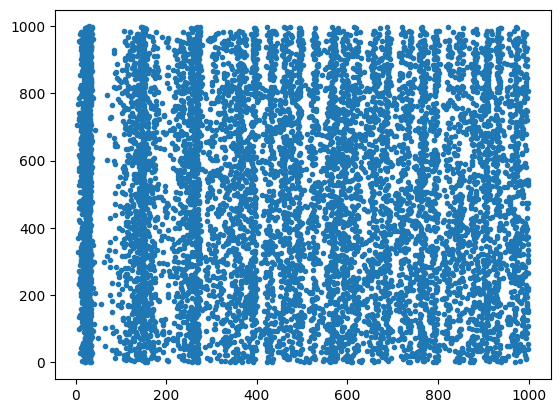

In [8]:
# Single run
net = PulseNetwork()
net.compile()

t, n = net.run()
plt.plot(t, n, '.')

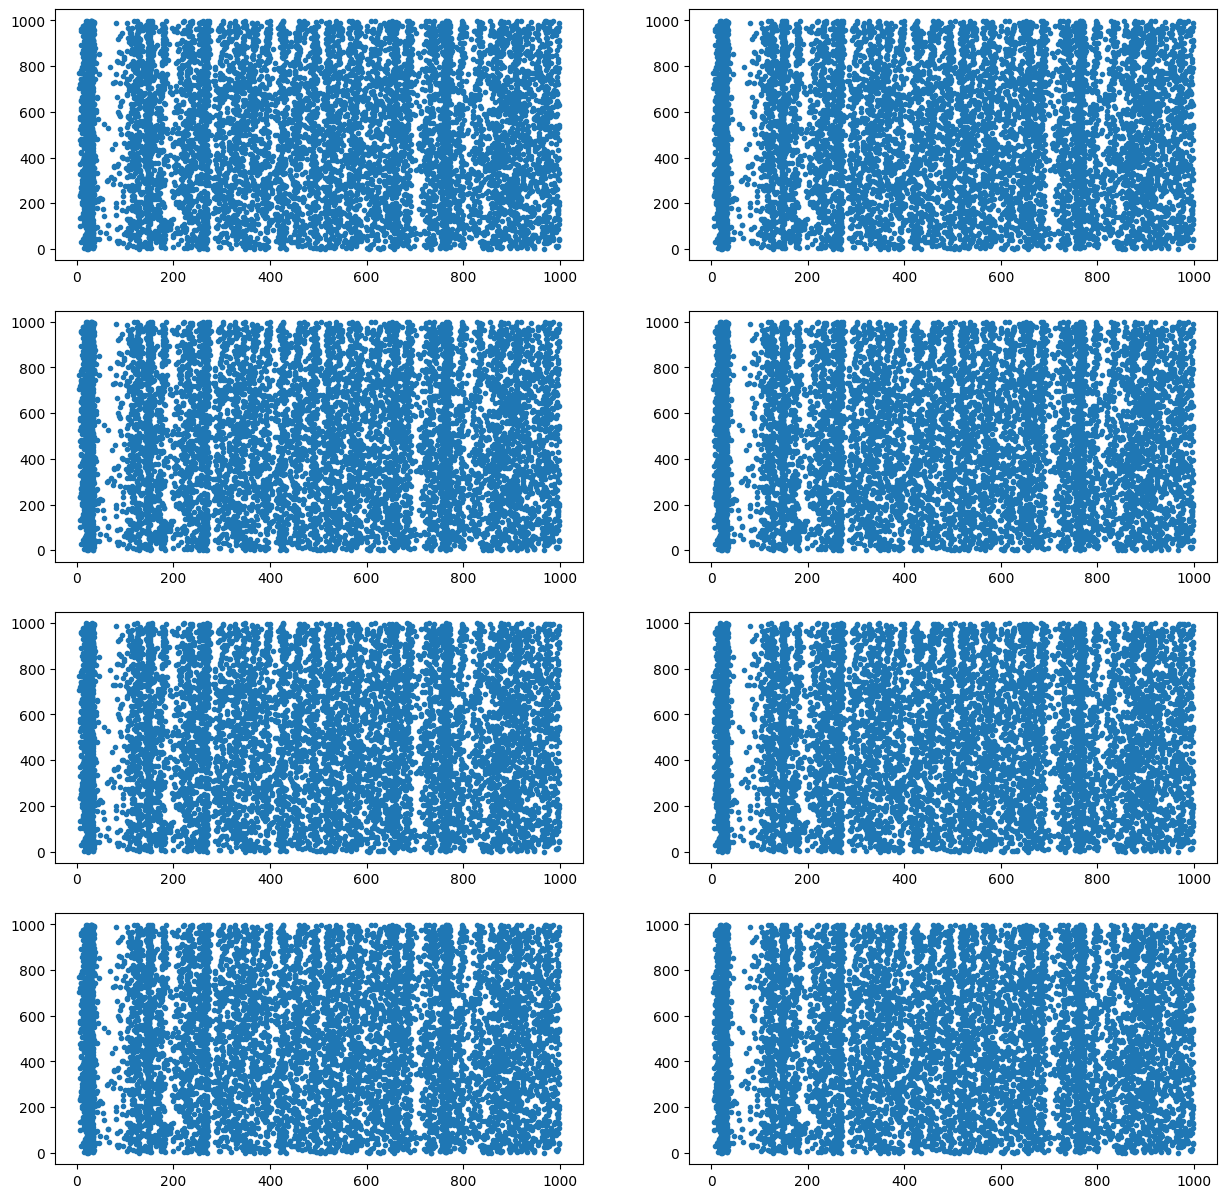

In [10]:
import time

import multiprocessing as mp
import platform
if platform.system() == "Darwin":
    mp.set_start_method('fork', force=True)

def _create_and_run_method(args):
    """
    Method called to wrap the user-defined method when different networks are created.
    """
    net = PulseNetwork()
    net.instantiate(import_id=9)

    t, n = net.run()
    del net
    return t, n

# List of values to process
values = [1, 2, 3, 4, 5, 6, 7, 8]

# Create a pool of worker processes
with mp.Pool(processes=8) as pool:
    results = pool.map(_create_and_run_method, values)

# Data analysis
plt.figure(figsize=(15, 15))
for i in range(8):
    t, n = results[i]
    plt.subplot(4, 2, i+1)
    plt.plot(t, n, '.')
plt.show()

In [11]:
ann.NetworkManager()

Number of registered networks = 10
Network 0 (MagicNetwork)
  populations = [Population at 0x128008d70, ]
  projections = [Projection at 0x12f17d880, Projection at 0x12f17d9a0, ]
  monitors = [Monitor at 0x12f17e210, ]
  extensions = []
  cyInstance = <module 'ANNarchyCore0' from '/Users/vitay/Research/ANNarchy/documentation/notebooks/annarchy//ANNarchyCore0.dylib'> at 0x12f198db0
Network 1 
  populations = [Population at 0x12f147590, ]
  projections = [Projection at 0x12f1477a0, Projection at 0x12f1469c0, ]
  monitors = [Monitor at 0x12f145ee0, ]
  extensions = []
  cyInstance = <module 'ANNarchyCore0' from '/Users/vitay/Research/ANNarchy/documentation/notebooks/annarchy//ANNarchyCore0.dylib'> at 0x12f198db0
Network 2 
  populations = [Population at 0x12f17ecc0, ]
  projections = [Projection at 0x12f17ebd0, Projection at 0x12f17dd60, ]
  monitors = [Monitor at 0x12f17e360, ]
  extensions = []
  cyInstance = <module 'ANNarchyCore0' from '/Users/vitay/Research/ANNarchy/documentation/not